In [323]:
# Alex Walczak | CS 189 | Homework 5 part 2: Decision Trees, Random Forests for Census Data

# Import functions and libraries
from __future__ import division
import numpy as np, matplotlib.pyplot as plt
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.io
from scipy import signal
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import rcParams
from sklearn.cross_validation import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
rcParams['figure.figsize'] = 7, 7
import csv
%matplotlib inline

In [575]:
### Imputing helpers

def most_freq_string(array):
    unique, all_inds_in_unique_for_items_in_array = np.unique(array,return_inverse=True)
    most_freq = unique[np.bincount(all_inds_in_unique_for_items_in_array).argmax()]
    return most_freq

def get_most_freq_feats(data, missing_value_symbol, categories, categorical_feats):
    # Arguments is a data matrix with each row being a sample.
    # Takes a majority vote on categorical features and computes mean on numerical features.
    clean_feats = np.array([np.array([feat for feat in complete_feat if feat != missing_value_symbol]) for complete_feat in data.T])
    res = []
    for j in range(len(clean_feats)): # each feature
        if categories[j] in categorical_feats:
            res += [most_freq_string(clean_feats[j])]
        else:
            res += [str(np.mean(clean_feats[j].astype(np.float)))]
    return np.array(res)

def impute_missing_value(data, replace_bad_feats_with, missing_value_symbol):
    # Arguments is a data matrix.
    for row in data:
        row[row == missing_value_symbol] = replace_bad_feats_with[row == missing_value_symbol]
        
### Evaluating splits
        
def probability(Y, C, S, distbn=None):
# probability of random variable Y being in class C
# index set S
    count = 0
    for i in S:
        if Y[int(i)] == C:
            count += 1
    return count/len(S)

def surprise(Y, C, S):
# surprise of random variable Y being in class C
    return -probability(Y, C, S)*((np.log(probability(Y, C, S)))/np.log(2))

def entropy(Y, classes, S):
# entropy of an index set S
# max = 1 occurs when Y is evenly split [ range = [0,1] ]
# (updating of entropy will be optimized, this is a naive version)
    H = 0
    for C in classes:
        H += surprise(Y, C, S)
    return H

def information_gain(Y, classes, S, Sleft, Sright):
    # change in entropy resulting from a split
    # we choose the split which maximizes this quanitity
    Hafter = (len(Sleft)*entropy(Y, classes, Sleft) + len(Sright)*entropy(Y, classes, Sright))/len(S)
    return entropy(Y, classes, S) - Hafter

def weighted_sum_of_entropy(Y, classes, S, Sleft, Sright):
    # we choose the split which MINimizes this quanitity
    Hafter = (len(Sleft)*entropy(Y, classes, Sleft) + len(Sright)*entropy(Y, classes, Sright))/len(S)
    return entropy(Y, classes, S) - Hafter

def gini_impurity(Y, classes, S):
    # Y can be thought of as a vector of labels, where a label equals a class C in classes.
    # we are only interested in the labels indexed by S. The other samples aren't being worked on.
    sum_prob_squared = 0
    for C in classes:
        sum_prob_squared+=(probability(Y, C, S)**2)
    return 1-sum_prob_squared

### Pruning-related

def postprune(node, ogtree, tdata, tlabels):
    if node == None:
        return
    if node.label!=None:
        return
        
    postprune(node.left, ogtree, tdata, tlabels)
    postprune(node.right, ogtree, tdata, tlabels)
    
    error_before = np.sum(tlabels != ogtree.predict_all(tdata))/len(tlabels)
    testasleaf(node)
    error_after = np.sum(tlabels != ogtree.predict_all(tdata))/len(tlabels)

    if error_after <= error_before:
        converttoleaf(node)
    else:
        undotestasleaf(node)

def testasleaf(node):
    # if a node label is not None, the children are never looked at. 
    # so to prune, we can just set node labels!
    if int(np.rint(node.split_rule[1])) >= 1:
        node.label = 1
    else:
        node.label = 0

def undotestasleaf(node):
    node.label = None
    
def converttoleaf(node):
    node.left = None
    node.right = None
    node.split_rule = None

def countnodesandleaves(node):
    if node == None:
        return 0
    if node.label != None:
        return 1
    else:
        return 1 + countnodesandleaves(node.left) + countnodesandleaves(node.right)
    
### Uncategorized functions

from __future__ import print_function

# Ex. save_labels(spam_labels,'kaggle_spam_mean.csv')
def save_labels(labels, fname):
    f1 = open(fname, 'w+')
    print('Id,Category', file = f1)
    for i in range(len(labels)):
        print(str(i+1)+","+str(int(labels[i])), file = f1)

def generate_inds(data, percent_train, with_replacement=False):
    if not with_replacement:
        rand_inds = np.random.permutation(len(data))
        train_inds = rand_inds[len(data)//percent_train:]
        test_inds = rand_inds[:len(data)//percent_train]
    else:
        train_inds = np.random.choice(len(data), size=len(data), replace=True)
        test_inds = np.random.permutation(len(data))[:len(data)//percent_train]
    return train_inds, test_inds

def avg_prediction(trees, data):
    predicted_labels = []
    for tree in trees:
        predicted_labels += [tree.predict_all(data)]
    predicted_labels = np.array([predicted_labels])
    return np.rint(np.mean(predicted_labels, axis = 1))

def grow_set_trees(num_trees, percent_train, data, labels, treetype='DecisionTree', depth=None, m=None, size_to_stop=None, bagging=False, prune=False):
    trees = []
    for t in range(num_trees):
        print(t+1)
        train_inds, unused = generate_inds(data, percent_train, with_replacement=bagging)
        training = data[train_inds]
        training_labels = labels[train_inds]
        
        if treetype == 'DecisionTree':
            tree = DecisionTree(size_to_stop)
        if treetype == 'RandomForest':
            tree = RandomForest(size_to_stop, m)
  
        tree.train(tree.root, data, labels, depth)

        if prune:
            XXX, prune_inds = generate_inds(data, percent_train)
            pruneset = data[prune_inds]
            prune_labels = labels[prune_inds]
            postprune(tree.root, tree, pruneset, prune_labels)

        trees += [tree]
    return trees

### Cross validation functions

def kfold(k, which, data, labels, hyperparam_set, treetype='DecisionTree', depth=None, m=None, size_to_stop=None, bagging=False):
    """which is one of: 'depth', 'm', 'size_to_stop'."""
    if which == 'depth':
        kfold_depth(k, data, labels, hyperparam_set, treetype, depth, m, size_to_stop, bagging)
        return
    
    if which == 'm':
        assert treetype == 'RandomForest'
        kfold_m(k, data, labels, hyperparam_set, 'RandomForest', depth, m, size_to_stop, bagging)
        return
    
    if which == 'size_to_stop':
        kfold_size_to_stop(k, data, labels, hyperparam_set, treetype, depth, m, size_to_stop, bagging)
        return

def kfold_m(k, data, labels, ms, treetype='RandomForest', depth=None, m=None, size_to_stop=None, bagging=False):
    kf = KFold(data.shape[0], n_folds=k, shuffle = True)
    m_errors = np.zeros(len(ms))

    for i in range(len(ms)):

        print('At m:', ms[i])

        for train, test in kf:

            ktrain = data[train]
            ktrain_label = labels[train]
            ktest = data[test]
            ktrue = labels[test]

            tree = RandomForest(size_to_stop, ms[i])
            tree.train(tree.root, ktrain, ktrain_label, depth)

            predn_labels = tree.predict_all(ktest);
            m_errors[i] += (np.sum(predn_labels != ktrue)/len(ktrue))*(1/k)

        print('Error:', m_errors[i])

    plt.figure()
    plt.plot(ms, m_errors)
    plt.title('Result of K-fold CV for m value of '+treetype+', size_to_stop = '+str(size_to_stop)+', depth = '+str(depth))
    plt.xlabel('m value')
    plt.ylabel('Average Error')
    
    print('Best m:',ms[m_errors.argmin()])

def kfold_depth(k, data, labels, depths, treetype='DecisionTree', depth=None, m=None, size_to_stop=None, bagging=False):
    kf = KFold(data.shape[0], n_folds=k, shuffle = True)
    depth_errors = np.zeros(len(depths))

    for i in range(len(depths)):

        print('At depth:', depths[i])

        for train, test in kf:

            ktrain = data[train]
            ktrain_label = labels[train]
            ktest = data[test]
            ktrue = labels[test]

            if treetype == 'DecisionTree':
                tree = DecisionTree(size_to_stop)
            if treetype == 'RandomForest':
                tree = RandomForest(size_to_stop, m)
            tree.train(tree.root, ktrain, ktrain_label, depths[i])

            predn_labels = tree.predict_all(ktest)
            depth_errors[i]+=(np.sum(predn_labels != ktrue)/len(ktrue))*(1/k)

        print('Error:', depth_errors[i])

    plt.figure()
    plt.plot(depths, depth_errors)
    plt.title('Result of K-fold CV for Depth of '+treetype+', size_to_stop = '+str(size_to_stop))
    plt.xlabel('Depth')
    plt.ylabel('Average Error')
    
    print('Best depth:',depths[depth_errors.argmin()])
    
def kfold_size_to_stop(k, data, labels, s2s, treetype='DecisionTree', depth=None, m=None, size_to_stop=None, bagging=False):
    kf = KFold(data.shape[0], n_folds=k, shuffle = True)
    s2s_errors = np.zeros(len(s2s))

    for i in range(len(s2s)):

        print('At size_to_stop:', s2s[i])

        for train, test in kf:

            ktrain = data[train]
            ktrain_label = labels[train]
            ktest = data[test]
            ktrue = labels[test]

            if treetype == 'DecisionTree':
                tree = DecisionTree(s2s[i])
            if treetype == 'RandomForest':
                tree = RandomForest(s2s[i], m)
            tree.train(tree.root, ktrain, ktrain_label, depth)

            predn_labels = tree.predict_all(ktest)
            s2s_errors[i]+=(np.sum(predn_labels != ktrue)/len(ktrue))*(1/k)

        print('Error:', s2s_errors[i])

    plt.figure()
    plt.plot(s2s, s2s_errors)
    plt.title('Result of K-fold CV for size_to_stop of '+treetype+', depth = '+str(depth))
    plt.xlabel('Size_to_stop')
    plt.ylabel('Average Error')
    
    print('Best size_to_stop:',s2s[s2s_errors.argmin()])

In [716]:
class DecisionTree:
    # for two-class data with binary features vectorized samples.
    class Node:
        def __init__(self, left=None, right=None, label=None, split_rule=None):
            self.left = left
            self.right = right
            self.label = label
            self.split_rule = split_rule # (feature, threshhold)
    
    def __init__(self, SMALLEST_OK_LEAF=1):
        self.SMALLEST_OK_LEAF = SMALLEST_OK_LEAF
        self.root = self.Node()
        
    def segmenter(self, data, labels, depth):
        # A method that takes in data and labels. When called, it finds the best split rule
        # for a Node using the impurity measure and input data.
        
        # stopping conditions
        if len(labels) <= self.SMALLEST_OK_LEAF:
            return None
        
        if (np.sum(labels) == 0 or np.sum(labels) == len(labels)):
            return None
        
        num_features = len(data[0])
        
        # which feature to split on?
        impurities = np.zeros(num_features)
        for j in range(num_features):
            # suppose split on j, quantify the split quality.
            left_label_hist = [[0,0],[1,0]]
            right_label_hist = [[0,0],[1,0]]
                
            left_label_hist[1][1] = np.sum(labels[np.where(data[:,j] == 0)]) # number of ones in left split
            right_label_hist[1][1] = np.sum(labels[np.where(data[:,j] == 1)])
            left_label_hist[0][1] = len(labels[np.where(data[:,j] == 0)]) - left_label_hist[1][1] # number of zeros (is the rest of left data)
            right_label_hist[0][1] = len(labels[np.where(data[:,j] == 1)]) - right_label_hist[1][1]

            impurities[j] = self.impurity(left_label_hist, right_label_hist)
            if (np.isnan(impurities[j])):
                print('ENCOUNTERED NAN')
                print(left_label_hist, right_label_hist)
                
        if np.min(impurities) == 0:
            return None
        
        else:
            return np.argmin(impurities) # best feature
        
    def train(self, tree, data, labels, depth=2):
        # Grows a decision tree by constructing nodes.
        
        # A stopping condition (too deep or empty node)
        if depth <= 0 or len(data)==0:
            average = np.sum(labels)/len(labels)
            if average >= 0.5:
                label = 1
            else:
                label = 0
            tree.label = label
            return tree
        
        split_point = self.segmenter(data, labels, depth)
        if split_point == None:
            if int(np.rint(np.mean(labels))) >= 1:
                tree.label = 1
            else:
                tree.label = 0
        else:
            left_inds = np.where(data[:,split_point] == 0)
            right_inds = np.where(data[:,split_point] == 1)
            left_data = data[left_inds]
            right_data = data[right_inds]
            left_labels = labels[left_inds]
            right_labels = labels[right_inds]
            tree.split_rule = (split_point, np.mean(data[:,split_point]))
            tree.left = self.train(self.Node(), left_data, left_labels, depth-1)
            tree.right = self.train(self.Node(), right_data, right_labels, depth-1)
        return tree

    def predict(self, data, show=False, i=5):
        # Traverses the tree to find the best label to classify the data point.
        cur_node = self.root
        origi = i
        if show:
            wohs = []
        while (cur_node.label == None and i):
            split_point = cur_node.split_rule[0]
            thresh = cur_node.split_rule[1]
            if show:
                wohs += [ (split_point, data[split_point], thresh) ]
                print(origi-i+1, split_point, data[split_point], thresh)
                i-=1
            if (data[split_point] < thresh):
                cur_node = cur_node.left
            else:
                cur_node = cur_node.right
            if (cur_node.label>1):
                print(cur_node.split_rule)
                print(cur_node.label)
        return int(cur_node.label)
    
    def predict_all(self, test_data):
        predns = [0,0]
        pred_labels = []
        errors = 0
        for i in range(len(test_data)):
            sample = test_data[i]
            predn = self.predict(sample)
            if predn > 1:
                print(predn)
            predns[predn] += 1
            pred_labels += [predn]
        plt.stem(predns)
        plt.xlim([-.2,1.2])
        plt.title('Number of each class')
#         print('Preidcted 1 : Total ratio =', predns[1]/len(test_data))
        return np.array(pred_labels)
    
    def WSE(self, left_label_hist, right_label_hist):
        return self.weighted_sum_of_entropy(left_label_hist, right_label_hist)
    
    def weighted_sum_of_entropy(self, left_label_hist, right_label_hist):
        # we choose the split which MINimizes this quanitity
        # for spam, two hists may be: ex. [( (0, 134), (1, 57)), ( (0, 12), (1, 19))]
        # card_X -> cardinality of X histogram
        card_left = left_label_hist[0][1] + left_label_hist[1][1]
        card_right = right_label_hist[0][1] + right_label_hist[1][1]
        return (card_left*self.entropy(left_label_hist) + card_right*self.entropy(right_label_hist))/(card_left+card_right+1e-11)
    
    def entropy(self, hist):
        # of a node, often a proposed node.
        # hist = (...,(feature_i, frequency),...)
        total = hist[0][1] + hist[1][1] + 1e-15
        prob0 = hist[0][1]/total
        prob1 = hist[1][1]/total
        return prob0*self.surprise(prob0) + prob1*self.surprise(prob1)
        
    def surprise(self, probability):
        return -((np.log(probability + 1e-15))/np.log(2))

    def impurity(self, left_label_hist, right_label_hist):
    # A method that takes in the result of a split: two histograms (a histogram is a mapping
    # from label values to their frequencies) that count the frequencies of labels on the ”left”
    # and ”right” side of that split. The method calculates and outputs a scalar value
    # representing the impurity (i.e. the ”badness”) of the specified split on the input data.
    # for spam: ( (0, 134), (1, 57))
        card_left = left_label_hist[0][1] + left_label_hist[1][1]
        card_right = right_label_hist[0][1] + right_label_hist[1][1]
        return ((card_left)*(gini_impurity(left_label_hist)) + (card_right)*(gini_impurity(right_label_hist)))/(card_left+card_right+1e-13)
    
def gini_impurity(hist):
    # Y can be thought of as a vector of labels, where a label equals a class C in classes.
    # we are only interested in the labels indexed by S. The other samples aren't being worked on.
    sum_prob_squared = 0
    card = hist[0][1] + hist[1][1]
    sum_prob_squared = (hist[0][1]/(card+1e-13))**2 + (hist[1][1]/(card+1e-13))**2
    return 1-sum_prob_squared

In [717]:
class RandomForest:
    # for two-class data with binary features vectorized samples.
    class Node:
        def __init__(self, left=None, right=None, label=None, split_rule=None):
            self.left = left
            self.right = right
            self.label = label
            self.split_rule = split_rule # (feature, threshhold)
    
    def __init__(self, SMALLEST_OK_LEAF=1, m=7):
        # random subset features used at each split, size equals "m" in range [1,d].
        self.m = m
        self.SMALLEST_OK_LEAF = SMALLEST_OK_LEAF
        self.root = self.Node()
        
    def segmenter(self, data, labels, depth):
        # A method that takes in data and labels. When called, it finds the best split rule
        # for a Node using the impurity measure and input data.
        
        # stopping conditions
        if len(labels) <= self.SMALLEST_OK_LEAF:
            return None
        
        if (np.sum(labels) == 0 or np.sum(labels) == len(labels)):
            return None
        
        # Random Subspace Selection
        features = np.random.permutation(len(data[0]))[:self.m]
        
        # which feature to split on?
        impurities = np.zeros(len(features))
        for imp_idx in range(len(features)):
            j = features[imp_idx]
            # suppose split on j, quantify the split quality.
            left_label_hist = [[0,0],[1,0]]
            right_label_hist = [[0,0],[1,0]]
                
            left_label_hist[1][1] = np.sum(labels[np.where(data[:,j] == 0)]) # number of ones in left split
            right_label_hist[1][1] = np.sum(labels[np.where(data[:,j] == 1)])
            left_label_hist[0][1] = len(labels[np.where(data[:,j] == 0)]) - left_label_hist[1][1] # number of zeros (is the rest of left data)
            right_label_hist[0][1] = len(labels[np.where(data[:,j] == 1)]) - right_label_hist[1][1]
            
            impurities[imp_idx] = checknan = self.impurity(left_label_hist, right_label_hist)

            if (np.isnan(checknan)):
                print('ENCOUNTERED NAN')
                print(left_label_hist, right_label_hist)
                
        if np.min(impurities) == 0:
            return None
        
        else:
            return features[np.argmin(impurities)] # best feature is indexed in features!
        
    def train(self, tree, data, labels, depth=2):
        # Grows a decision tree by constructing nodes.
        
        # A stopping condition (too deep or empty node)
        if depth <= 0 or len(data)==0:
            average = np.sum(labels)/len(labels)
            if average >= 0.5:
                label = 1
            else:
                label = 0
            tree.label = label
            return tree
        
        split_point = self.segmenter(data, labels, depth)
        if split_point == None:
            if int(np.rint(np.mean(labels))) >= 1:
                tree.label = 1
            else:
                tree.label = 0
        else:
            left_inds = np.where(data[:,split_point] == 0)
            right_inds = np.where(data[:,split_point] == 1)
            left_data = data[left_inds]
            right_data = data[right_inds]
            left_labels = labels[left_inds]
            right_labels = labels[right_inds]
            tree.split_rule = (split_point, np.mean(data[:,split_point]))
            tree.left = self.train(self.Node(), left_data, left_labels, depth-1)
            tree.right = self.train(self.Node(), right_data, right_labels, depth-1)
        return tree

    def predict(self, data, show=False, i=5):
        # Traverses the tree to find the best label to classify the data point.
        cur_node = self.root
        origi = i
#         while (cur_node.label == None and i):
#             split_point = cur_node.split_rule[0]
#             thresh = cur_node.split_rule[1]
#             if show:
#                 print(origi-i+1, split_point, thresh)
#                 i-=1
#             if (data[split_point] < thresh):
#                 cur_node = cur_node.left
#             else:
#                 cur_node = cur_node.right
#             if (cur_node.label>1):
#                 print(cur_node.split_rule)
#                 print(cur_node.label)
#         return int(cur_node.label)
        if show:
            wohs = []
        while (cur_node.label == None and i):
            split_point = cur_node.split_rule[0]
            thresh = cur_node.split_rule[1]
            if show:
                wohs += [ (split_point, data[split_point], thresh) ]
                print(origi-i+1, split_point, data[split_point], thresh)
                i-=1
            if (data[split_point] < thresh):
                cur_node = cur_node.left
            else:
                cur_node = cur_node.right
            if (cur_node.label>1):
                print(cur_node.split_rule)
                print(cur_node.label)
        if show:
            return wohs
        return int(cur_node.label)
    
    def predict_all(self, test_data):
        predns = [0,0]
        pred_labels = []
        errors = 0
        for i in range(len(test_data)):
            sample = test_data[i]
            predn = self.predict(sample)
            if predn > 1:
                print(predn)
            predns[predn] += 1
            pred_labels += [predn]
        plt.stem(predns)
        plt.xlim([-.2,1.2])
        plt.title('Number of each class')
#         print('Preidcted 1 : Total ratio =', predns[1]/len(test_data))
        return np.array(pred_labels)
    
    def WSE(self, left_label_hist, right_label_hist):
        return self.weighted_sum_of_entropy(left_label_hist, right_label_hist)
    
    def weighted_sum_of_entropy(self, left_label_hist, right_label_hist):
        # we choose the split which MINimizes this quanitity
        # for spam, two hists may be: ex. [( (0, 134), (1, 57)), ( (0, 12), (1, 19))]
        # card_X -> cardinality of X histogram
        card_left = left_label_hist[0][1] + left_label_hist[1][1]
        card_right = right_label_hist[0][1] + right_label_hist[1][1]
        return (card_left*self.entropy(left_label_hist) + card_right*self.entropy(right_label_hist))/(card_left+card_right+1e-11)
    
    def entropy(self, hist):
        # of a node, often a proposed node.
        # hist = (...,(feature_i, frequency),...)
        total = hist[0][1] + hist[1][1] + 1e-15
        prob0 = hist[0][1]/total
        prob1 = hist[1][1]/total
        return prob0*self.surprise(prob0) + prob1*self.surprise(prob1)
        
    def surprise(self, probability):
        return -((np.log(probability + 1e-15))/np.log(2))

    def impurity(self, left_label_hist, right_label_hist):
    # A method that takes in the result of a split: two histograms (a histogram is a mapping
    # from label values to their frequencies) that count the frequencies of labels on the ”left”
    # and ”right” side of that split. The method calculates and outputs a scalar value
    # representing the impurity (i.e. the ”badness”) of the specified split on the input data.
    # for spam: ( (0, 134), (1, 57))
        card_left = left_label_hist[0][1] + left_label_hist[1][1]
        card_right = right_label_hist[0][1] + right_label_hist[1][1]
        return ((card_left)*(gini_impurity(left_label_hist)) + (card_right)*(gini_impurity(right_label_hist)))/(card_left+card_right+1e-13)
    
def gini_impurity(hist):
    # Y can be thought of as a vector of labels, where a label equals a class C in classes.
    # we are only interested in the labels indexed by S. The other samples aren't being worked on.
    sum_prob_squared = 0
    card = hist[0][1] + hist[1][1]
    sum_prob_squared = (hist[0][1]/(card+1e-13))**2 + (hist[1][1]/(card+1e-13))**2
    return 1-sum_prob_squared

In [705]:
categorical_feats = np.array(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'])

In [706]:
# Load data

In [632]:
reader = csv.reader(open('census_data/train_data.csv','r'))
train_data = []
train_labels = []
for row in reader:
    train_data += [row[:-1]]
    train_labels += [row[-1]] # label is in last feature ~ last column
categories = np.array(train_data)[0] # first row
train_data = np.array(train_data)[1:] # skip first row entry = categories
train_labels = np.array(train_labels)[1:].astype(np.int) # skip first row entry = 'label'

In [633]:
# Impute '?' in data

In [634]:
mff = get_most_freq_feats(train_data, '?', categories, categorical_feats)
impute_missing_value(train_data, mff, '?')
print(mff)

['38.6681945972' 'Private' '189277.381891' 'HS-grad' '10.0763354113'
 'Married-civ-spouse' 'Exec-managerial' 'Husband' 'White' 'Male'
 '1094.81634275' '86.9095465102' '40.4178584525' 'United-States']


In [635]:
# fnlwgt class has too many unique values,
# so vectorizing isn't a good idea until I reduce it by centering and floor dividing:

In [636]:
fnlwgt_feat = 2
train_data[:,fnlwgt_feat] = ((train_data[:,fnlwgt_feat].astype(np.float) - ((train_data[:,fnlwgt_feat].astype(np.float).min())))//5000).astype('S26')

In [637]:
# Build a list of dictionaries, each dictionary corresponds to a sample

In [638]:
train_dicts = [dict(zip(categories, row)) for row in train_data] # each sample is now a dict. labels and samples still in order.

In [639]:
# Vectorize data, i.e, expand the features.

In [640]:
dv = DictVectorizer(sparse=False) # want regular 'ol arrays.
train_vectorized = dv.fit_transform(train_dicts)
categories_vectorized = np.array(dv.feature_names_) # new labels because we expanded categorical features (vectorized)

In [621]:
# Load Kaggle Data

In [622]:
reader = csv.reader(open('census_data/test_data.csv','r'))
kaggle_data = []
for row in reader:
    kaggle_data += [row]
kaggle_data = np.array(kaggle_data)[1:] # skip first row entry = categories

print(mff)
impute_missing_value(kaggle_data, mff, '?')

fnlwgt_feat = 2
kaggle_data[:,fnlwgt_feat] = ((kaggle_data[:,fnlwgt_feat].astype(np.float) - ((train_data[:,fnlwgt_feat].astype(np.float).min())))//5000).astype('S26')

kaggle_dicts = [dict(zip(categories, row)) for row in kaggle_data] # each test sample is now a dict.

kaggle_vectorized = dv.transform(kaggle_dicts) # don't fit to this! only transform it, because we want the labels on training and test to match.

['38.6681945972' 'Private' '189277.381891' 'HS-grad' '10.0763354113'
 'Married-civ-spouse' 'Exec-managerial' 'Husband' 'White' 'Male'
 '1094.81634275' '86.9095465102' '40.4178584525' 'United-States']


In [367]:
# Train a decision tree on census data.

In [499]:
pt = 10
train_inds, test_inds = generate_inds(train_vectorized, pt)
XXX, prune_inds = generate_inds(train_vectorized, pt)

training = train_vectorized[train_inds]
training_labels = train_labels[train_inds]

test = train_vectorized[test_inds]
test_labels = train_labels[test_inds]

pruneset = train_vectorized[prune_inds]
prune_labels = train_labels[prune_inds]

In [718]:
biggest_leaf_when_stop_okay = 7
depth = 10

dt = DecisionTree(biggest_leaf_when_stop_okay)
dt.train(dt.root, training, training_labels, depth)
print(countnodesandleaves(dt.root))

321


Error 0.143948655257


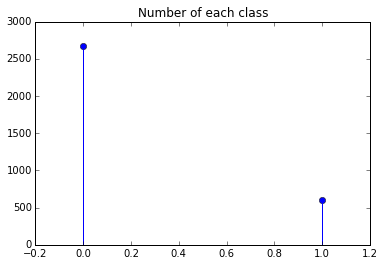

In [719]:
predn_labels = dt.predict_all(test);
print('Error', np.sum(predn_labels != test_labels)/len(test_labels))

In [435]:
# Train a random forest on census data.

m = int(np.rint(0.666*(len(categories_vectorized))))
print('m:', m)

biggest_leaf_when_stop_okay = 2
forest_depth = 10

rf = RandomForest(biggest_leaf_when_stop_okay, m)
rf.train(rf.root, training, training_labels, forest_depth)

predn_labels = rf.predict_all(test);
print('Error:', np.sum(predn_labels != test_labels)/len(test_labels))

In [ ]:
# Build T decision trees, average their result. Samples chosen by bagging.

In [588]:
training = train_vectorized[train_inds]
training_labels = train_labels[train_inds]

test = train_vectorized[test_inds]
test_labels = train_labels[test_inds]

In [674]:
num_trees = 10
pt = 10
treetype = 'DecisionTree'
depth = 13
m = 220
size_to_stop = 1
bagging = True
prune = False

trees = grow_set_trees(num_trees, pt, training, training_labels, treetype, depth, m, size_to_stop, bagging, prune)

('Error of 20 trees:', 0.14058679706601468)


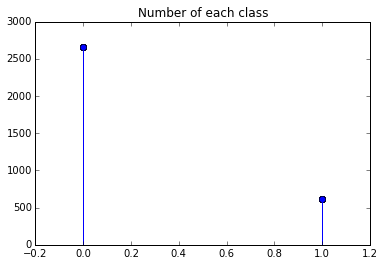

In [562]:
avg_predn_trees_labels = avg_prediction(trees, test)
print('Error of 10 trees:', np.sum(avg_predn_trees_labels != test_labels)/len(test_labels))

In [673]:
pruned_trees = []
count = 0
for tree in trees:
    
    print('before', count, countnodesandleaves(tree.root))
    
    XXX, prune_inds = generate_inds(training, pt)
    pruneset = training[prune_inds]
    prune_labels = training_labels[prune_inds]
    postprune(tree.root, tree, pruneset, prune_labels)
    
    print('after', count, countnodesandleaves(tree.root))

    pruned_trees += [tree]
    count+=1

('Error of 20 pruned trees:', 0.13722493887530562)


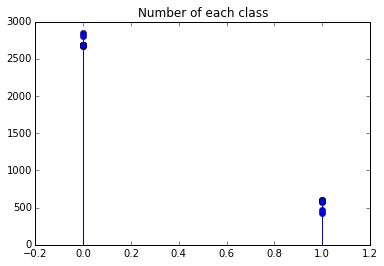

In [568]:
avg_predn_pruned_trees_labels = avg_prediction(pruned_trees, test)
print('Error of 10 pruned trees:', np.sum(avg_predn_pruned_trees_labels != test_labels)/len(test_labels))

In [ ]:
# forests below

In [735]:
num_trees = 10
pt = 10
treetype = 'RandomForest'
depth = 400
m = 36
size_to_stop = 1
bagging = True
prune = False

random_forests = grow_set_trees(num_trees, pt, train_vectorized, train_labels, treetype, depth, m, size_to_stop, bagging, prune)

avg_predn_forests_labels = avg_prediction(random_forests, test)
print('Error of 10 random forests:', np.sum(avg_predn_forests_labels != test_labels)/len(test_labels))

0.081461719816354389

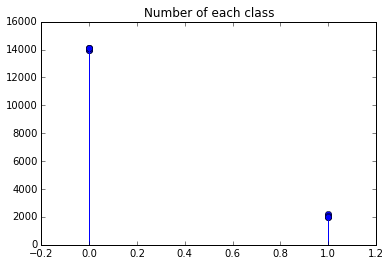

In [682]:
kaggle_pdn_labels = np.array(avg_prediction(random_forests, kaggle_vectorized))[0]
np.sum(kaggle_pdn_labels)/len(kaggle_pdn_labels)

In [681]:
save_labels(kaggle_pdn_labels, 'cenus_labels_400depth10trees.csv')
# Kaggle Score: 0.75533

In [456]:
# KFold CV on depths for Decision Tree.

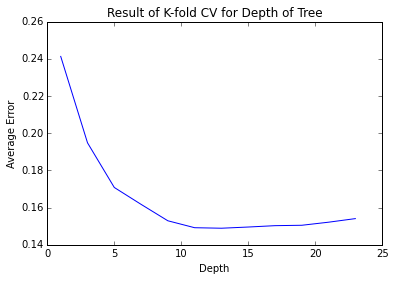

In [464]:
plt.plot(depths[:12], depth_errors[:12])
plt.title('Result of K-fold CV for Depth of Tree')
plt.xlabel('Depth')
plt.ylabel('Average Error')
# min at 13 when size_to_stop = 7

In [ ]:
# ### sw
# ms = [220]
# kfold(5,'size_to_stop',training,training_labels,[1],'DecisionTree',depth=13,size_to_stop=None)
# kfold(5,'depth',training,training_labels,depths,'DecisionTree',size_to_stop=7)
# kfold(5,'m',training,training_labels,ms,'RandomForest',depth=13,size_to_stop=1)